
<!-- Latest compiled and minified CSS -->
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css" integrity="sha384-BVYiiSIFeK1dGmJRAkycuHAHRg32OmUcww7on3RYdg4Va+PmSTsz/K68vbdEjh4u" crossorigin="anonymous">

<!-- Optional theme -->
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap-theme.min.css" integrity="sha384-rHyoN1iRsVXV4nD0JutlnGaslCJuC7uwjduW9SVrLvRYooPp2bWYgmgJQIXwl/Sp" crossorigin="anonymous">

<!-- Latest compiled and minified JavaScript -->
<script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/js/bootstrap.min.js" integrity="sha384-Tc5IQib027qvyjSMfHjOMaLkfuWVxZxUPnCJA7l2mCWNIpG9mGCD8wGNIcPD7Txa" crossorigin="anonymous"></script>

<div class="jumbotron" style="background:#80B1FF;   border-radius: 10px; padding: 20px 20px 20px 20px;">
<h1 class="page-title" align="Center"> Fast Fourier Transform </h1>
<h3 align="center" style="color:white"> Camilo Valenzuela Carrasco  <font style="color:gray;">201173030-5 </font> </h3>
</div>
<style> .output_png {text-align: center;} </style>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

from numba import jit
from dst import *
import scipy.fftpack as sfft

%matplotlib inline

In [2]:
%%HTML 
<style> .output_png {text-align: center;} </style>

## Discrete Fourier Transform
La Transformada de Fourier aproxima una funcion $f(x)$ en la suma de funciones llevandolo al plano de fourier.
$${\displaystyle {\hat {f}}(k )=\int _{-\infty }^{\infty }f(x)\ e^{-2\pi ixk }\,dx,}$$

Si se discretiza la función se obtiene la **Transformada de Fourier Discreta** que supone la función periódica
$${\displaystyle {\begin{aligned}X_{k}&=\sum _{n=0}^{N-1}x_{n}\cdot e^{-i2\pi kn/N}\\&=\sum _{n=0}^{N-1}x_{n}\cdot [\cos(2\pi kn/N)-i\cdot \sin(2\pi kn/N)],\end{aligned}}} $$

Esta transformada tiene una complejidad $O(N^2)$.

In [3]:
"""
Implementación simple de Discrete Fourier Transform.
"""
def DFT(fnList):
    N = len(fnList)
    FmList = np.zeros(N,dtype='complex')
    for m in range(N):
        for n in range(N):
            FmList[m] += fnList[n] * np.exp(- 2j * np.pi * m * n / N)
    return FmList

"""
Discrete Fourier Transoform Discreta.
"""
def iDFT(FmList):
    N = len(FmList)
    fnList = np.zeros(N,dtype='complex')
    for n in range(N):
        for m in range(N):
            fnList[n] += FmList[m] * np.exp(2j * np.pi * m * n / N)
    return fnList/N

## Fast Fourier Transform (Recursiva)
Fast Fourier Transform (FFT) es un algoritmo para calcular la Transformada de Fourier discreta de forma más rápida pasando de **$O(N^2)$** a **$O(N log(N))$**, eso lo logra **dividiendo la sumatoria** entre los coeficientes **pares** e **impares**

In [4]:
"""
Implementación Simple de Fast Fourier Transform utilizando recursividad.
"""
def fft(x):
    N = len(x)
    if N <= 1:
        return x
    even = fft(x[0::2])
    odd =  fft(x[1::2])
    
    N_2 = int(N/2)
    k = np.arange(N_2)
    T= np.exp(-2j*np.pi*k/N)*odd
    return np.append(even + T ,even - T)

"""
Implementación de Fast Fourier Transform
"""
def ifft(x):
    x = x.real - 1j*x.imag
    res = fft(x)/len(x)
    return res.real - 1j*res.imag

## Comparación entre DFT y FFT

In [5]:
def experiment0_1D():
    Ns = 2**np.arange(4,11)
    errors = []
    times_dft = []
    times_fft = []
    times_np = []
    for N in Ns:
        f = np.random.rand(N)
        t0 = time.time()
        x_dft = DFT(f)
        times_dft.append(time.time()-t0)
        t0 = time.time()
        x_fft = fft(f)
        times_fft.append(time.time()-t0)
        t0 = time.time()
        x_np = np.fft.fft(f)
        times_np.append(time.time()-t0)
    fig, ax1 = plt.subplots(1,1, figsize=(7,7))
    ax1.loglog(Ns,times_dft)
    ax1.loglog(Ns,times_fft)
    ax1.loglog(Ns, times_np)
    ax1.legend(["DFT","FFT", "np.fft.fft (Numpy)"])
    ax1.set_title("Complexity")
    plt.show()

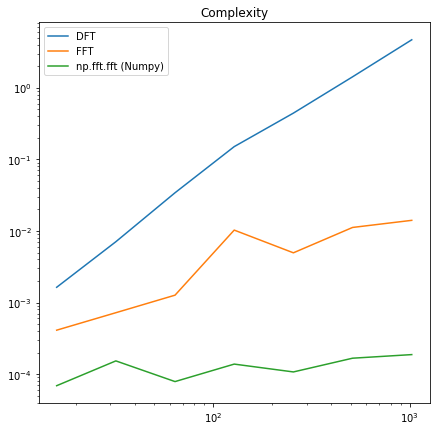

In [6]:
experiment0_1D()

## Transformada de Fourier en 2D
Como la integral y la sumatoria son operadores lineales, se puede calcular la transformada de fourier para dimensiones mayores utilizando la transformada en 1D.

$${\displaystyle \begin{align}
X_{u,v}&=\sum_{m = 0}^{M-1}\sum _{n=0}^{N-1}x_{m,n}\cdot e^{-\frac{i2\pi un}{N} - \frac{i2\pi vm}{M}}\\
       &= \sum_{m = 0}^{M-1}\left(\sum _{n=0}^{N-1}x_{m,n}\cdot e^{-\frac{i2\pi un}{N}}\right) e^{- \frac{i2\pi vm}{M}}\\
       &=  \sum_{m = 0}^{M-1} X_{m,u}e^{- \frac{i2\pi vm}{M}}
\end{align}}$$

Por lo que calcular la transformada de Fourier en 2D se puede realizar utilizando la FFT en una dimensión y luego en la otra. 

In [7]:
def DFT2(fnList):
    fnList = fnList.astype('complex')
    n_x,n_y = fnList.shape
    
    for x in range(n_x):
        fnList[x,:] = DFT(fnList[x,:])
    
    for y in range(n_y):
        fnList[:,y] = DFT(fnList[:,y])
        
    return fnList

def iDFT2(FmList):
    FmList = FmList.astype('complex')
    n_x,n_y = FmList.shape
    
    for y in range(n_y):
        FmList[:,y] = iDFT(FmList[:,y])    
    
    for x in range(n_x):
        FmList[x,:] = iDFT(FmList[x,:])
    return FmList

In [8]:
def fft2(x):
    x = x.astype('complex')
    n_x,n_y = x.shape
    
    for i in range(n_x):
        x[i,:] = fft(x[i,:])
    
    for j in range(n_y):
        x[:,j] = fft(x[:,j])
    
    return x


def ifft2(x):
    x = x.astype('complex')
    n_x, n_y = x.shape

    for j in range(n_y):
        x[:,j] = ifft(x[:,j])    
    
    for i in range(n_x):
        x[i,:] = ifft(x[i,:])
        
    return x

In [9]:
def experiment0_2D():
    Ns = 2**np.arange(4,7)
    errors = []
    times_dft = []
    times_fft = []
    times_np = []
    for N in Ns:
        f = np.random.rand(N,N)
        t0 = time.time()
        x_approx = DFT2(f)
        times_dft.append(time.time()-t0)
        t0 = time.time()
        x_approx = fft2(f)
        times_fft.append(time.time()-t0)
        t0 = time.time()
        x_np = np.fft.fft2(f)
        times_np.append(time.time()-t0)
    fig, ax1 = plt.subplots(1,1, figsize=(7,7))
    ax1.loglog(Ns,times_dft)
    ax1.loglog(Ns,times_fft)
    ax1.loglog(Ns,times_np)
    ax1.legend(["DFT","FFT","np.fft.fft2"])
    ax1.set_title("Complexity")
    ax1.grid()
    plt.show()

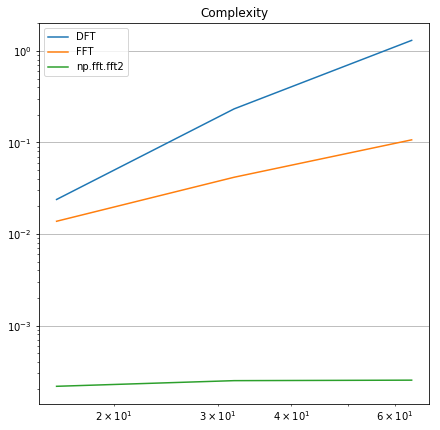

In [10]:
experiment0_2D()

## Problema
Tenemos el BVP 
$$ \frac{\partial^2 \phi}{\partial x^2}+ \frac{\partial^2 \phi}{\partial x^2}=\frac{1}{\pi^2}
\left[
30 \left(\left(\frac{x}{\pi}\right)^2 -\frac{x}{\pi} \right)
+ 30\left(\left(\frac{y}{\pi}\right)^2 -\frac{y}{\pi} \right) 
- 4 \pi^2 \left( \frac{x}{\pi} sin(2y) \right)
\right] = f(x,y)$$
en el cuadrado $0 < x,y < \pi$ donde $\phi(0,y) = \phi(\pi,y) = \phi(x,0) = \phi(x,\pi) = 0$

Como los bordes de nuestra ecuación son igual a 0, se puede utilizar la transformada de fourier de seno para obtener los coeficientes

In [11]:
def create_right(N):
    b = np.zeros((N,N))
    l = np.linspace(0,np.pi,N, endpoint=False)
    ly,lx = np.meshgrid(l,l)
    
    b  = 30 * ( (lx/np.pi)**2 - lx/np.pi )
    b += 30 * ( (ly/np.pi)**2 - ly/np.pi )
    b -= 4 * np.pi**2 * (lx/np.pi - 1) * np.sin(2*ly)
    b /= np.pi**2
    return b

In [12]:
def create_solution(N):
    sol = np.zeros((N,N))
    l = np.linspace(0,np.pi,N,endpoint=False)
    ly,lx = np.meshgrid(l,l)
    sol = 15 *(((lx/np.pi)**2 - lx/np.pi)  * ((ly/np.pi)**2 - ly/np.pi))
    sol -= np.sin(2*ly) * np.sinh(2*np.pi*(lx/np.pi -1))/np.sinh(2*np.pi)
    sol +=(lx/np.pi -1 )* np.sin(2*ly)
    return sol

In [13]:
def L2_error(f, f_exact):
    return np.sqrt(np.sum((f-f_exact)**2)/np.sum(f_exact**2))

## Método espectral
Dada las propiedades de la transformada de fourier al utilizarlo en nuestro problema tenemos
$$ \begin{align}
-u^2 \Phi(u,v) - v^2 \Phi(u,v) &= F(u,v) \\
\Phi(u,v) &= \frac{- F(u,v)}{(u^2 + v^2)}
\end{align}$$
Donde $\Phi(u,v)$ y $F(u,v)$ son las funciones $\phi$ y $f$ luego de aplicar la Transformada de Fourier (de seno), luego de aplicar la transformada de seno calculamos la Transformada de Fourier inversa (de seno) para obtener $\phi(x,y)$

In [14]:
def solve_BVP_spectral(f):
    N,_ = f.shape
    F = dst2(f)
    U = np.zeros_like(f)
    for i in range(N):
        for j in range(N):
            if i != 0 or j !=0:
                U[i,j] = -F[i,j]/ (i**2+j**2)
            
    return idst2(U)

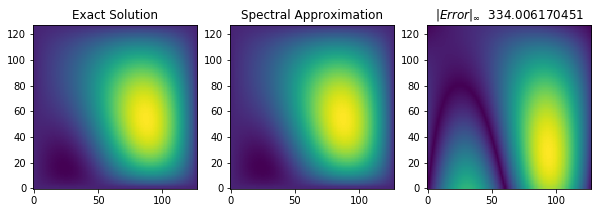

In [15]:
N = 128
f = create_right(N)
x = create_solution(N)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,7))
ax1.imshow(x,origin="lower")
ax1.set_title("Exact Solution")
ax2.imshow(solve_BVP_spectral(f),origin="lower")
ax2.set_title("Spectral Approximation")
err = np.abs(f - solve_BVP_spectral(f))
ax3.imshow(err,origin="lower")
ax3.set_title(r"$|Error|_{\infty}$  "+str(np.linalg.norm(err,np.inf)))
plt.show()

In [16]:
def experiment1(function=solve_BVP_spectral):
    Ns = 2**np.arange(4,12)
    errors = []
    times = []
    for N in Ns:
        f = create_right(N)
        x = create_solution(N)
        t0 = time.time()
        x_approx = function(f)
        times.append(time.time()-t0)
        errors.append(L2_error(x_approx,x))
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,7))
    ax1.loglog(Ns,errors)
    ax1.set_title("Convergence")
    ax2.loglog(Ns,times)
    ax2.set_title("Complexity")
    ax1.grid()
    ax2.grid()
    plt.show()
    return errors, times

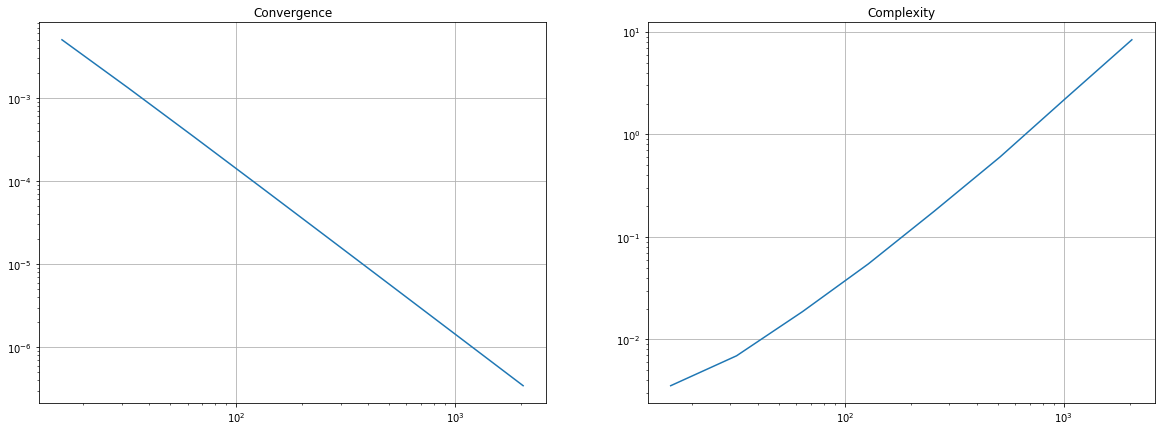

In [17]:
s_err, s_times = experiment1()

## Diferencias Finitas Aceleradas (2D)
Como hemos visto una derivada puede ser aproximada utilizando Diferencias Finitas, en este caso buscaremos acelerarlas con FFT para obtener un mejor resultado en una grilla más gruesa.

Sea
$$ \phi_{xx} = \frac{\phi_{i-1,j} - 2 \phi_{i,j} + \phi_{i+1,j}}{h^2} , \phi_{yy} = \frac{\phi_{i,j-1} - 2 \phi_{i,j} + \phi_{i,j+1}}{h^2}$$

La ecuación puede ser aproximada de la forma
$$  (\phi_{i-1,j} + \phi_{i+1,j})+(\phi_{i,j-1} + \phi_{i,j+1}) - 4 \phi_{i,j}  = h^2f_{i,j}$$
Si utilizamos DST (Discrete Sine Transform)
$$  (\Phi_{u-1,v} + \Phi_{u+1,v})+(\Phi_{u,v-1} + \Phi_{u,v+1}) - 4 \Phi_{u,v}  = h^2F_{u,v}$$

Una de las propiedades de la transformada de fourier del seno
$$(\Phi_{u-a,v} + \Phi_{u+a,v}) = 2 cos(au) \Phi_{u,v}$$

Por lo que nuestra ecuación se puede escribir con respecto a $\Phi_{u,v}$
$$ \Phi_{u,v} \left(  2 cos(u) \Phi_{u,v} +  2 cos(v) \Phi_{u,v} - 4 \right) = h^2 F_{u,v}$$

Despejando $\Phi_{u,v}$
$$ \Phi_{u,v} = \frac{h^2 F_{u,v}}{ 2 cos(u) \Phi_{u,v} +  2 cos(v) \Phi_{u,v} - 4 } $$
Con $u = \frac{2 \pi}{N}i , v = \frac{2 \pi}{M}j$

In [18]:
def solve_BVP_diff2(f):
    N,_ = f.shape
    F = dst2(f)
    U = np.zeros_like(F)
    h = np.pi/N
    l = np.arange(N)
    j,i = np.meshgrid(np.arange(N),np.arange(N))
    for i in range(N):
        for j in range(N):
            if (2 * np.cos(i*np.pi/N) + 2 * np.cos(j*np.pi/N) - 4 ) != 0:
                U[i,j] = h**2*F[i,j]/(2 * np.cos(i*np.pi/N) +2 * np.cos(j*np.pi/N) - 4 )
    return idst2(U)

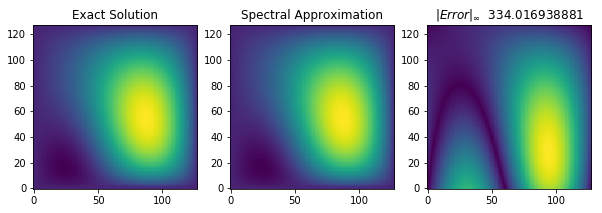

In [19]:
N = 128
f = create_right(N)
x = create_solution(N)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,7))
ax1.imshow(x,origin="lower")
ax1.set_title("Exact Solution")
ax2.imshow(solve_BVP_diff2(f),origin="lower")
ax2.set_title("Spectral Approximation")
err = np.abs(f - solve_BVP_diff2(f))
ax3.imshow(err,origin="lower")
ax3.set_title(r"$|Error|_{\infty}$  "+ str(np.linalg.norm(err,np.inf)) )
plt.show()

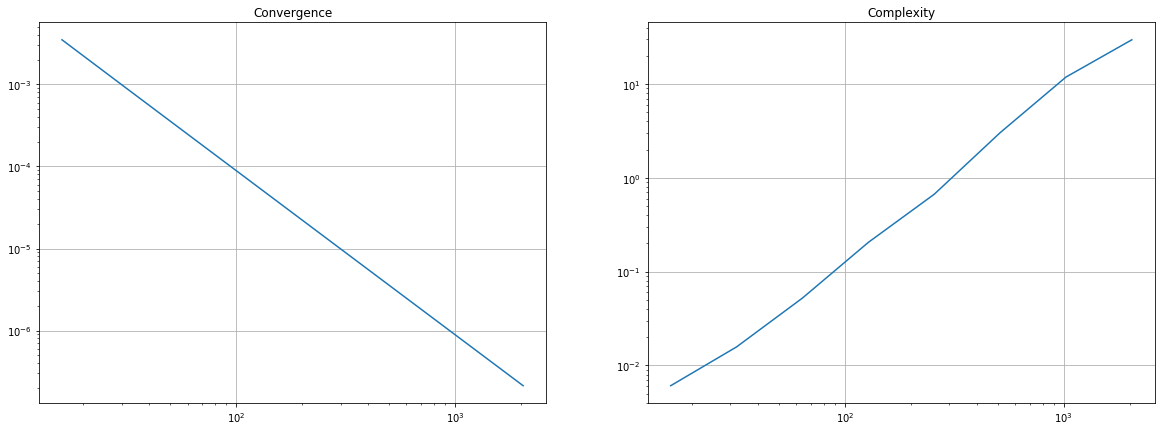

In [20]:
diff_err, diff_times=experiment1(solve_BVP_diff2)

In [21]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def dst_axis(x):
    M, N = np.shape(x)
    x = x[1:M-1,:]
    M,N = np.shape(x)
    y = np.zeros((2*(M+1),N))
    y[0,:] = np.zeros(N)[:]
    y[1:M+1,:] = x[:,:]
    y[M+1,:] = np.zeros(N)[:]
    y[M+2:2*M+ 2,:] = -np.flipud(x)[:,:]
    y_t = np.fft.fft(np.transpose(y))
    y_t = np.transpose(y_t)
    y = np.real((y_t[1:M+1])/(-1j*(M+1)))
    yy = np.zeros((M+2,N))
    yy[1:M+1,:] = y[:,:]
    return yy

def idst_axis(x):
    r = dst_axis(x)
    return (r.shape[0]/2) * r

def solve_BVP_1D(f):
    N = f.shape[0]
    h = np.pi/N
    d2F   = (h**2) * dst_axis(f)
    U     = np.zeros((N, N))
    for n in range(1,N-1):
        ec = sp.diags([1, 2*np.cos(np.pi*n/N) - 4, 1], [-1, 0, 1], shape=(N-2,N-2), format="csr")
        U[n,1:-1] = spla.spsolve(ec, d2F[n,1:-1])
    return idst_axis(U)

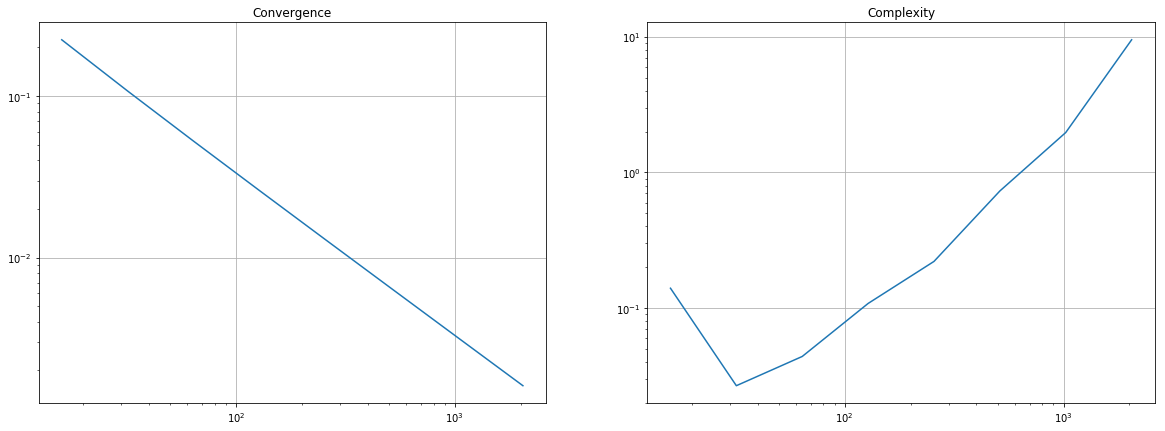

In [22]:
diff1D_err, diff1D_times=experiment1(solve_BVP_1D)

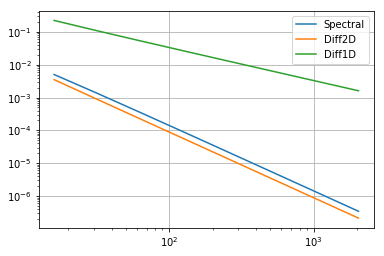

In [23]:
Ns =2**np.arange(4,12)
plt.loglog(Ns,s_err)
plt.loglog(Ns,diff_err)
plt.loglog(Ns,diff1D_err)
plt.legend(["Spectral", "Diff2D","Diff1D"])
plt.grid()
plt.show()

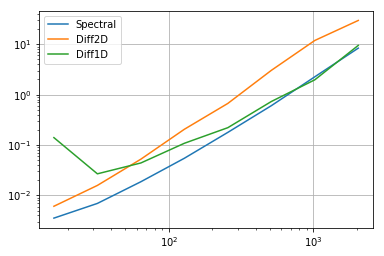

In [24]:
plt.loglog(Ns,s_times)
plt.loglog(Ns,diff_times)
plt.loglog(Ns,diff1D_times)
plt.legend(["Spectral", "Diff2D", "Diff1D"])
plt.grid()
plt.show()